In [40]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def Gaussian_pdf(x,name,para):
    mu=para[name+'_mean']
    sigma=para[name+'_sd']
    return math.exp(((x-mu)/sigma)**2*(-1/2))/(sigma*math.sqrt(2*math.pi))
def normialise(tem_dist):
    return [tem_dist[i]/sum(tem_dist) for i in range(len(tem_dist))]
def second_moment(name,para):
    return para[name+'_mean']**2+para[name+'_sd']**2
def c_generate(x_range):
    bin=len(x_range)
    C=np.random.random((bin,bin))
    for i in range(bin):
        for j in range(bin):
            C[i,j]=abs(x_range[i]-x_range[j])
    return C
def algorithms(reg,m,n,g,f,C):
    K=np.exp(-C/C.max()/reg)
    interations=100
    trial=10 #check the optimiality every trial. 
    u=np.ones((n,1))
    u_record=np.ones((n,1))
    for tri in range(trial):
        if sum(abs(u_record-u))<10**(-10):
            for i in range(1,interations):
                v=g/np.dot(K.T,u)
                u=f/np.dot(K,v)
            u_record=u
        else:
            break
    return np.dot(np.diag(u.reshape((1,-1))[0]),np.dot(K,np.diag(v.reshape((1,-1))[0])))

def assess(m,n,g,f,C,output):
    print('sum of violation of f:',sum(abs(np.sum(output,1)-f.reshape(n))))
    print('sum of violation of g:',sum(abs(np.sum(output,0)-g.reshape(m))))
    print('total cost:',sum(sum(output*C)))
    print('entropy:',sum(sum(-output*np.log(output+0.1**3))))
    print('============================================')

def plots(x_range,g,f,output):
    fig = plt.figure(figsize=(4, 3))
    gs = fig.add_gridspec(2, 2, width_ratios=(bin, 1), height_ratios=(1, bin),left=0.1, right=0.9, bottom=0.1, top=0.9,wspace=0.05, hspace=0.05)
    # Create the Axes.
    ax = fig.add_subplot(gs[1, 0])
    ax.pcolormesh(x_range, x_range, output, cmap='Blues')
    # ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    # ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    # ax_histx.tick_params(axis="x", labelbottom=False)
    # ax_histy.tick_params(axis="y", labelleft=False)
    # ax_histx.plot(x_range,g)
    # ax_histy.plot(f,x_range) 

def OT(reg,x_range,g,f):
    m=len(g)
    n=len(f)
    C=c_generate(x_range)
    output=algorithms(reg,m,n,g.reshape(m,-1),f.reshape(n,-1),C)
    assess(m,n,g,f,C,output)
    plots(x_range,g,f,output)
    return output

def empirical_distribution(sub,dist):
    bin=dist['bin']
    distrition=np.zeros(bin)
    for i in range(bin):
        subset=sub[sub['X']==i] #bin_value=x_range[i] #sub[(sub['X']>=bin_value)&(sub['X']<bin_value+width)]
        if subset.shape[0]>0:
            distrition[i]=sum(subset['W'])
    if sum(distrition)>0:
        return distrition/sum(distrition)
    else:
        return distrition

def barycenter_projection(df,coupling,para): # for baselines
    U=df['U'].iloc[0]
    df_f=df[df['S']=='f']
    df_m=df[df['S']=='m']
    pi0=para['pi_'+U+'f']
    pi1=para['pi_'+U+'m']

    rows,cols=np.nonzero(coupling)
    num_nzero=len(rows)
    sub=pd.DataFrame(columns=['X','W'],index=range(num_nzero))

    sub['X']=np.floor((pi0*x_range[cols]+pi1*x_range[rows]-horizen[0])/width)
    W_col=[Gaussian_pdf(x_range[c],'X_'+U+'f',para)*width for c in cols]
    W_row=[Gaussian_pdf(x_range[r],'X_'+U+'m',para)*width for r in rows]
    sub['W']=coupling[rows,cols] #*W_col*W_row
    sub['U']=U #df['U'].iloc[0]
    sub=sub[sub['W']!=0]
    sub_f=sub.copy()
    sub_m=sub.copy()
    sub_f['S']='f'
    sub_m['S']='m'
    return pd.concat([sub_f,sub_m], ignore_index=True)

def KL_divergence_plot(dist_tmp):
    text=[]
   
    pf=dist_tmp['x_f']
    pm=dist_tmp['x_m']
    q=dist_tmp['x']
    q_supp=np.nonzero(q)[0]
    klf=0
    klm=0
    for i in q_supp: #range(bin):
        if pf[i]!=0:
            klf+=pf[i]*math.log(pf[i]/q[i])
        if pm[i]!=0:
            klm+=pm[i]*math.log(pm[i]/q[i])
    # print('KL(x_{u='+u+',s=f}||x_{u='+u+'}):', round(klf,4))
    # print('KL(x_{u='+u+',s=m}||x_{u='+u+'}):', round(klm,4))
    # text+=['KL(x_{u='+u+',s=f}||x_{u='+u+'}): '+str(round(klf,4))]
    # text+=['KL(x_{u='+u+',s=m}||x_{u='+u+'}): '+str(round(klm,4))]
    text+=['KL(~||x: '+str(round(klf,4))]
    text+=['KL(~||x: '+str(round(klm,4))]
    return text

def KL_divergence(p,q):
    text=[]
    #name=list(dist_tmp.keys())[0]
    #p=dist_tmp['t_x']
    #q=dist_tmp['x']
    q_supp=np.nonzero(q)[0]
    kl=0
    for i in q_supp: #range(bin):
        if p[i]!=0:
            kl+=p[i]*math.log(p[i]/q[i])
    return kl

def data_generation(num,para):
    df=pd.DataFrame(columns=['X', 'S'])
    for name in ['f','m']:
        size=int(para[name]*num)
        X=np.floor((np.random.normal(para['X_'+name+'_mean'],para['X_'+name+'_sd'],size=[size])-horizen[0])/width)
        #np.random.normal(para['X_'+name+'_mean'],para['X_'+name+'_sd'],size=[size])
        S=[name]*size
        df=pd.concat([df, pd.DataFrame([X,S], index=['X','S']).T], ignore_index=True)
    df['W']=1
    df['X']=df['X'].astype('int64')  
    return df

def samples_groupby(data):
    # for better complexity
    df=data.groupby(by=['X','S'],as_index=False).sum()
    return df[df['W']!=0]

def projection(df,coupling):
    df_t=pd.DataFrame(columns=['X','S','W'])
    for i in range(df.shape[0]):
        orig=df.iloc[i]
        rows=np.nonzero(coupling[:,orig[0]])[0]
        sub=pd.DataFrame(columns=['X','W'],index=rows)
        sub['X']=rows
        sub['W']=coupling[rows,orig[0]]/(sum(coupling[rows,orig[0]])+0.0001)*orig[2]
        sub['S']=orig[1]
        df_t=pd.concat([df_t, samples_groupby(sub)], ignore_index=True)
    return df_t

In [2]:
def barycenter_projection1(df,coupling,para):
    #U=df['U'].iloc[0]
    df_f=df[df['S']=='f']
    df_m=df[df['S']=='m']
    pi0=para['pi_'+'f']
    pi1=para['pi_'+'m']
    new_coupling_f=np.zeros((bin,bin))
    #new_coupling_m=np.zeros((bin,bin))
    for i in range(bin):
        for j in range(bin):
            ind_f=int(pi0*i+pi1*j)
      #      ind_m=int(pi0*j+pi1*i)
            new_coupling_f[ind_f,i]+=coupling[j,i]
     #       new_coupling_m[ind_m,i]+=coupling[i,j]
    df_Bf=projection(df_f,new_coupling_f)
    #df_Bm=projection(df_m,new_coupling_m)
    return df_Bf #pd.concat([df_Bf,df_Bm], ignore_index=True)

In [60]:
para = dict()
para['X_f_mean']=-8
para['X_f_sd']=5
para['X_m_mean']=para['X_f_mean']+8
para['X_m_sd']=1
para['f']=0.3
para['m']=0.7
para['pi_f']=para['f'] #para['f_a']
para['pi_m']=1-para['pi_f']

horizen=[-50,50]
width=0.1
reg=0.01 
bin=int((horizen[1]-horizen[0])/width)
x_range=np.arange(horizen[0],horizen[1],width)
dist = dict(zip(['horizen','width','bin','x_range'],[horizen,width,bin,x_range]))
dist['x_f']=[Gaussian_pdf(x,'X_f',para)*width for x in x_range]
dist['x_m']=[Gaussian_pdf(x,'X_m',para)*width for x in x_range]
dist['x']=[dist['x_f'][i]*para['f']+dist['x_m'][i]*para['m'] for i in range(bin)]
#dist['t_x']=normialise([dist['x_f'][i]**para['f']*dist['x_m'][i]**para['m'] for i in range(bin)])  
dist['t_x']=dist['x'][700:1000]+dist['x'][0:700]

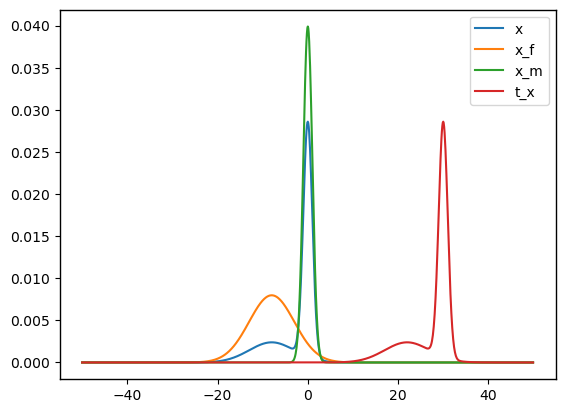

In [61]:
plt.plot(x_range,dist['x'],label='x')
plt.plot(x_range,dist['x_f'],label='x_f')
plt.plot(x_range,dist['x_m'],label='x_m')
plt.plot(x_range,dist['t_x'],label='t_x')
plt.legend()

In [69]:
dist['t_x_old']=normialise([dist['x_f'][i]**para['f']*dist['x_m'][i]**para['m'] for i in range(bin)]) 

top:x
right:t_x
sum of violation of f: 1.1306889775424044e-16
sum of violation of g: 7.11742701297233e-16
total cost: 30.000000463375827
entropy: 6.717144322777573


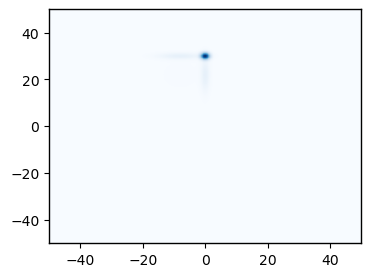

In [62]:
print('top:x')
print('right:t_x')
mu=np.array(dist['x'])
mu_t=np.array(dist['t_x'])
output=OT(reg,x_range,mu,mu_t)

top:x
right:t_x_old
sum of violation of f: 1.1715537192210464e-16
sum of violation of g: 1.5022022751700682e-14
total cost: 2.692818512141906
entropy: 6.520230242046574


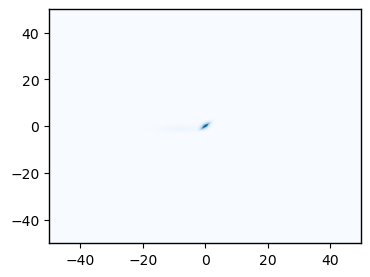

In [70]:
print('top:x')
print('right:t_x_old')
mu=np.array(dist['x'])
mu_t=np.array(dist['t_x_old'])
output_old=OT(reg,x_range,mu,mu_t)

In [75]:
num=1000
data=samples_groupby(data_generation(num,para))
data_revised=projection(data,output)
data_revised_old=projection(data,output_old)

dist_original=dict()
dist_original['x']=empirical_distribution(data,dist)
dist_original['x_f']=empirical_distribution(data[data['S']=='f'],dist)
dist_original['x_m']=empirical_distribution(data[data['S']=='m'],dist)

dist_project=dict()
dist_project['x']=empirical_distribution(data_revised,dist)
dist_project['x_f']=empirical_distribution(data_revised[data_revised['S']=='f'],dist)
dist_project['x_m']=empirical_distribution(data_revised[data_revised['S']=='m'],dist)

dist_project_old=dict()
dist_project_old['x']=empirical_distribution(data_revised_old,dist)
dist_project_old['x_f']=empirical_distribution(data_revised_old[data_revised_old['S']=='f'],dist)
dist_project_old['x_m']=empirical_distribution(data_revised_old[data_revised_old['S']=='m'],dist)

Text(0.5, 0.98, 'original dataset')

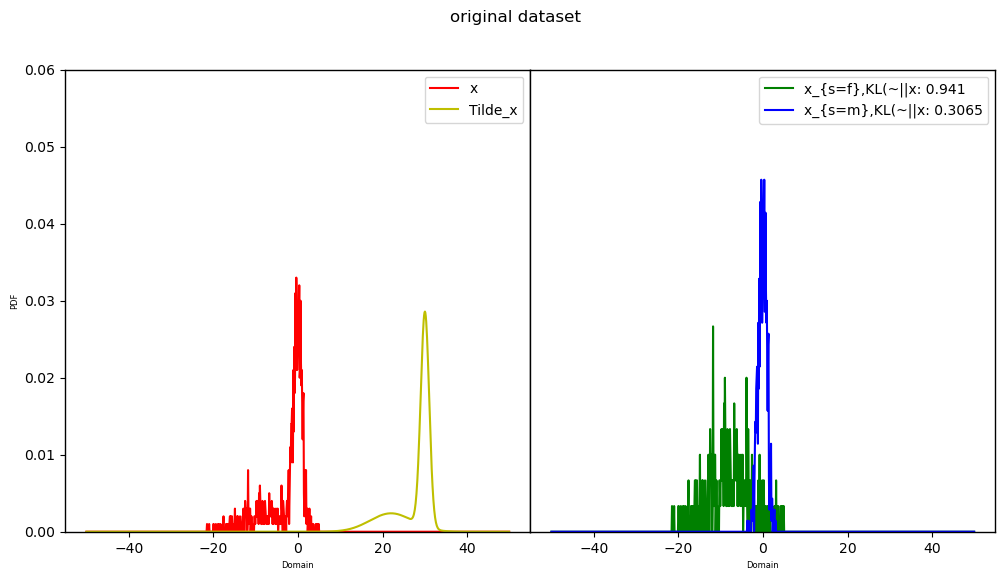

In [76]:
ymax=0.06
dist_tmp=dist_original
text=KL_divergence_plot(dist_tmp)
fig = plt.figure(figsize=(12,6))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
plt.plot(x_range,dist_tmp['x'],'r',label='x')
plt.plot(x_range,dist['t_x'],'y',label='Tilde_x')
plt.xlabel('Domain')
plt.ylabel('PDF')
plt.ylim([0,ymax])
plt.legend()
ax=plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
i=0
for key,value in dist_tmp.items():
    if len(key)>1:
        linestyle=str('g' if key[2]=='f' else 'b')
        plt.plot(x_range,value,linestyle,label='x_{s='+key[2]+'},'+text[i])
        i+=1
plt.xlabel('Domain')
plt.ylim([0,ymax])
plt.yticks([])
plt.legend()
#plt.title('original dataset distribution')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
fig.suptitle('original dataset')

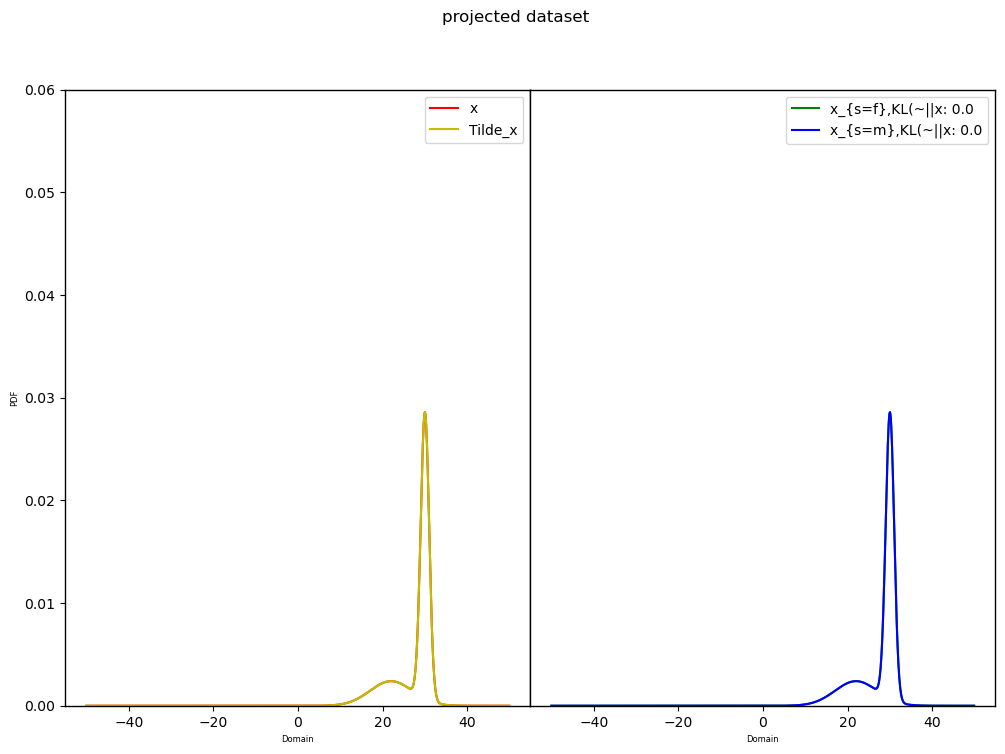

In [77]:
ymax=0.06
dist_tmp=dist_project
text=KL_divergence_plot(dist_tmp)
fig = plt.figure(figsize=(12,8))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
plt.plot(x_range,dist_tmp['x'],'r',label='x')
plt.plot(x_range,dist['t_x'],'y',label='Tilde_x')
plt.xlabel('Domain')
plt.ylabel('PDF')
plt.ylim([0,ymax])
plt.legend()
ax=plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
i=0
for key,value in dist_tmp.items():
    if len(key)>1:
        linestyle=str('g' if key[2]=='f' else 'b')
        plt.plot(x_range,value,linestyle,label='x_{s='+key[2]+'},'+text[i])
        i+=1
plt.xlabel('Domain')
plt.ylim([0,ymax])
plt.yticks([])
plt.legend()
#plt.title('original dataset distribution')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
fig.suptitle('projected dataset')
plt.savefig('projected.pdf',bbox_inches = 'tight')

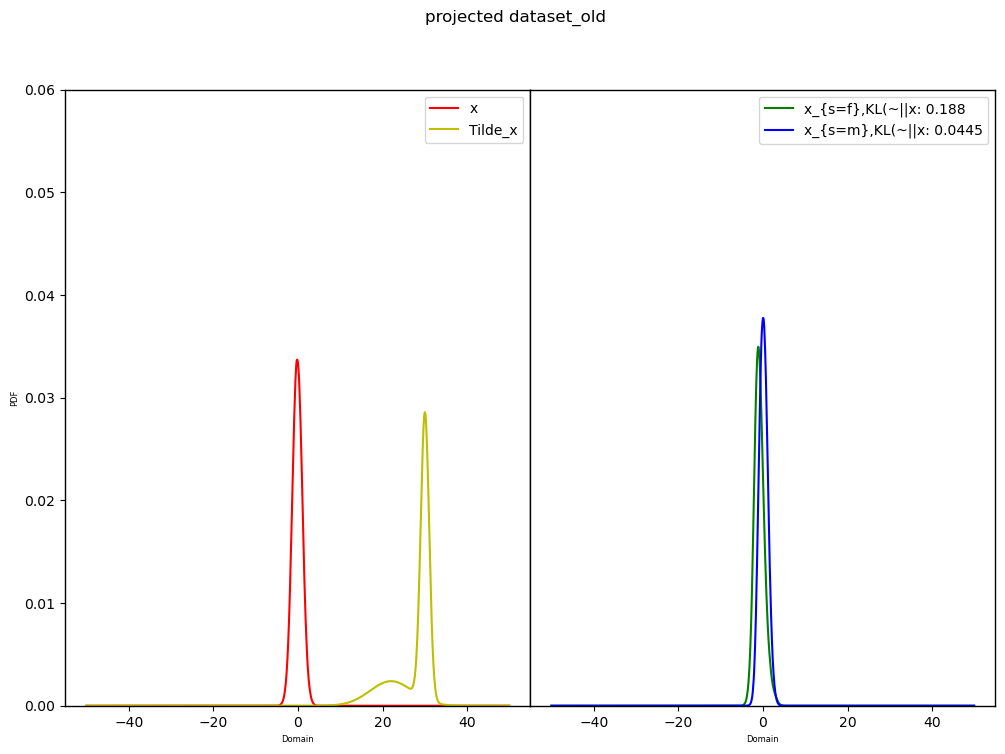

In [78]:
ymax=0.06
dist_tmp=dist_project_old
text=KL_divergence_plot(dist_tmp)
fig = plt.figure(figsize=(12,8))
plt.rcParams['axes.linewidth'] = 1
plt.rc('axes', labelsize=6) 
ax=plt.subplot2grid((1,2),(0,0), rowspan=1, colspan=1)
plt.plot(x_range,dist_tmp['x'],'r',label='x')
plt.plot(x_range,dist['t_x'],'y',label='Tilde_x')
plt.xlabel('Domain')
plt.ylabel('PDF')
plt.ylim([0,ymax])
plt.legend()
ax=plt.subplot2grid((1,2),(0,1), rowspan=1, colspan=1)
i=0
for key,value in dist_tmp.items():
    if len(key)>1:
        linestyle=str('g' if key[2]=='f' else 'b')
        plt.plot(x_range,value,linestyle,label='x_{s='+key[2]+'},'+text[i])
        i+=1
plt.xlabel('Domain')
plt.ylim([0,ymax])
plt.yticks([])
plt.legend()
#plt.title('original dataset distribution')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0,hspace=0.)
fig.suptitle('projected dataset_old')
plt.savefig('projected_old.pdf',bbox_inches = 'tight')

top:x_f
right:x_m
sum of violation of f: 1.3148489957984272e-16
sum of violation of g: 4.1778897961741475e-16
total cost: 1.9117176272070653
entropy: 6.610320069396772
top:x_f
right:x_m
sum of violation of f: 1.3148489957984272e-16
sum of violation of g: 4.1778897961741475e-16
total cost: 1.9117176272070653
entropy: 6.610320069396772
top:x_f
right:x_m
sum of violation of f: 1.3148489957984272e-16
sum of violation of g: 4.1778897961741475e-16
total cost: 1.9117176272070653
entropy: 6.610320069396772
top:x_f
right:x_m
sum of violation of f: 1.6779096513743395e-16
sum of violation of g: 4.339674889227035e-16
total cost: 1.954760160703549
entropy: 6.612248912330343
top:x_f
right:x_m
sum of violation of f: 1.6779096513743395e-16
sum of violation of g: 4.339674889227035e-16
total cost: 1.954760160703549
entropy: 6.612248912330343
top:x_f
right:x_m
sum of violation of f: 1.6779096513743395e-16
sum of violation of g: 4.339674889227035e-16
total cost: 1.954760160703549
entropy: 6.61224891233034

C:\Users\zhouq\AppData\Local\Temp\ipykernel_10268\3094111085.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(4, 3))


top:x_f
right:x_m
sum of violation of f: 1.772116766103177e-16
sum of violation of g: 3.7788607045310167e-16
total cost: 3.6820098474054004
entropy: 6.661674123175094
top:x_f
right:x_m
sum of violation of f: 1.772116766103177e-16
sum of violation of g: 3.7788607045310167e-16
total cost: 3.6820098474054004
entropy: 6.661674123175094
top:x_f
right:x_m
sum of violation of f: 1.772116766103177e-16
sum of violation of g: 3.7788607045310167e-16
total cost: 3.6820098474054004
entropy: 6.661674123175094
top:x_f
right:x_m
sum of violation of f: 1.3119805631554283e-16
sum of violation of g: 4.0233494616709463e-16
total cost: 4.121846856924146
entropy: 6.667682134172045
top:x_f
right:x_m
sum of violation of f: 1.3119805631554283e-16
sum of violation of g: 4.0233494616709463e-16
total cost: 4.121846856924146
entropy: 6.667682134172045
top:x_f
right:x_m
sum of violation of f: 1.3119805631554283e-16
sum of violation of g: 4.0233494616709463e-16
total cost: 4.121846856924146
entropy: 6.66768213417204

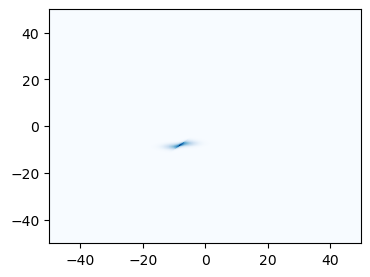

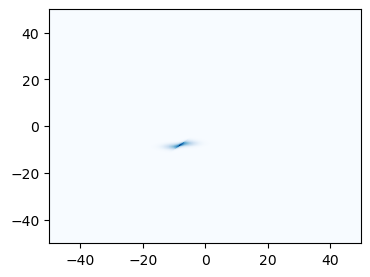

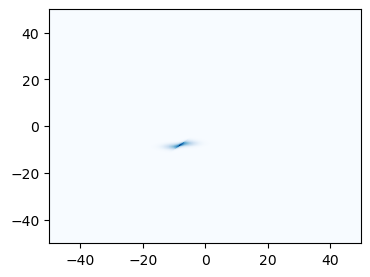

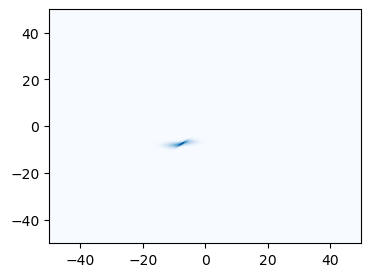

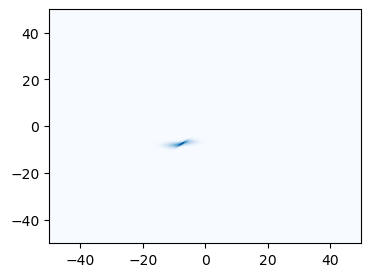

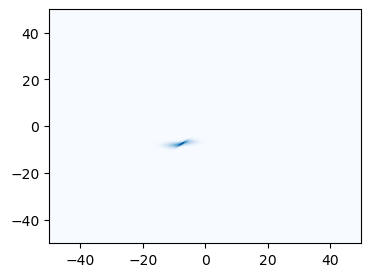

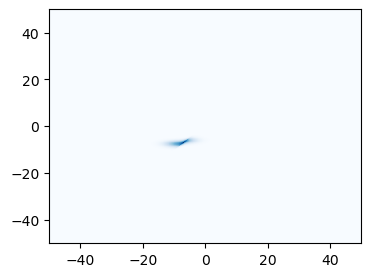

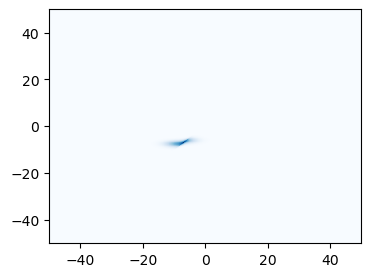

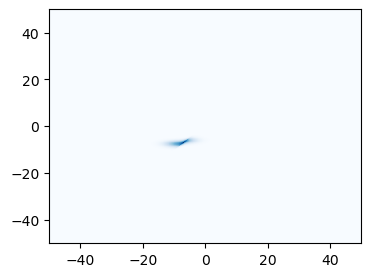

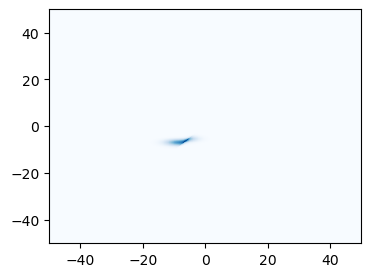

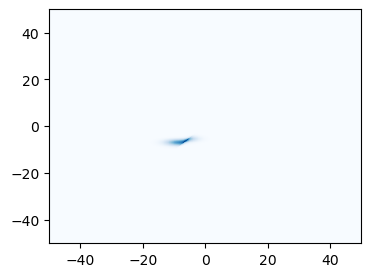

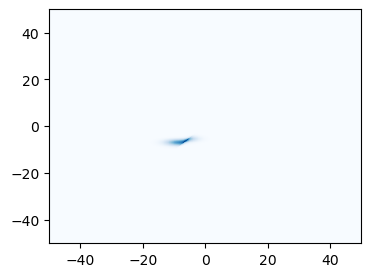

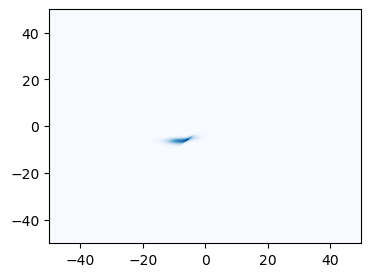

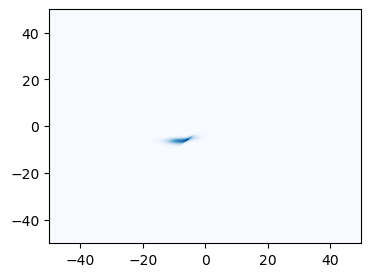

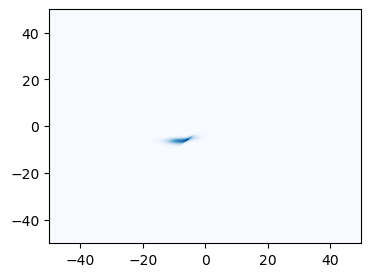

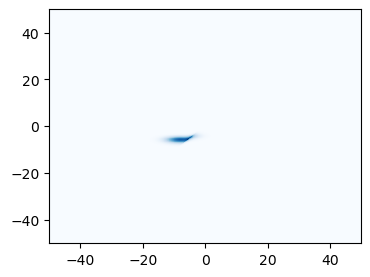

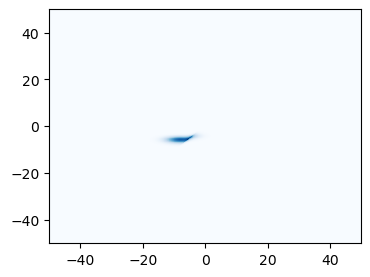

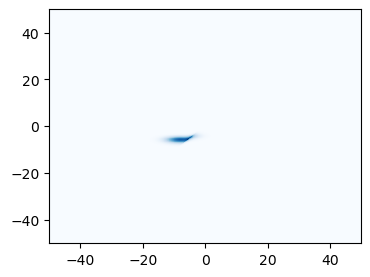

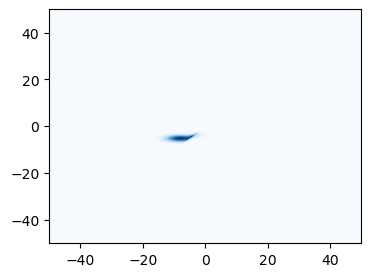

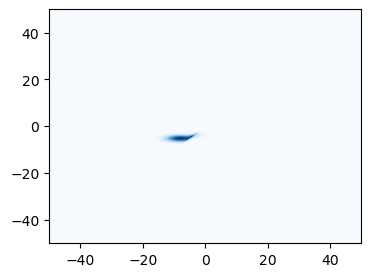

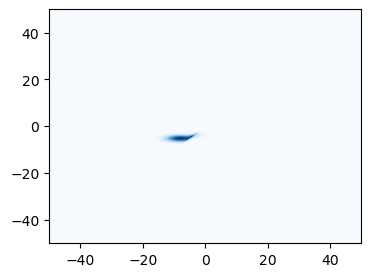

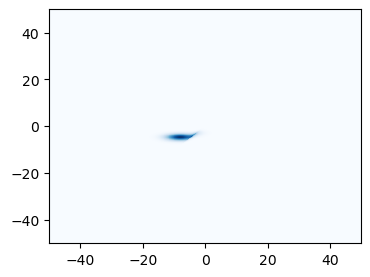

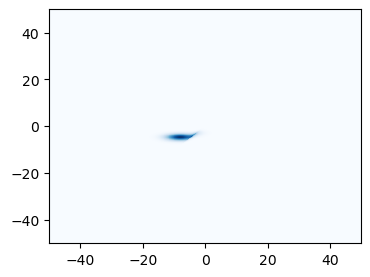

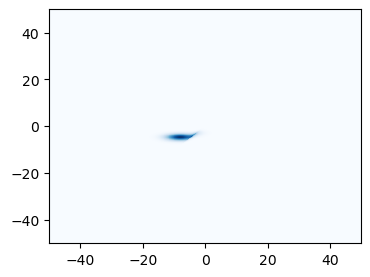

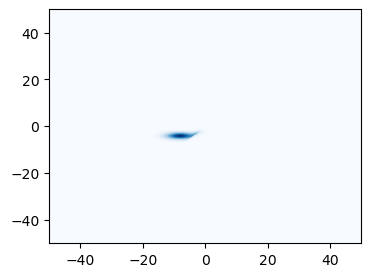

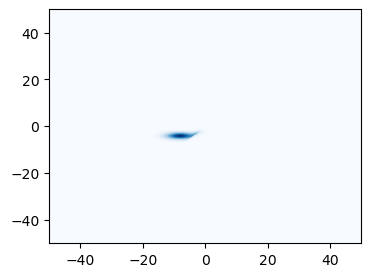

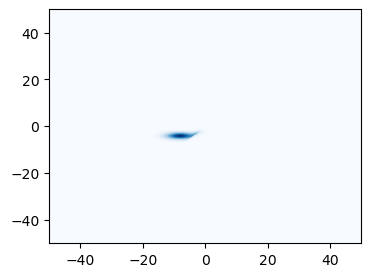

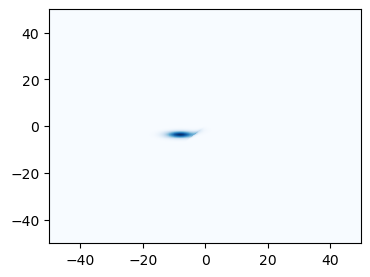

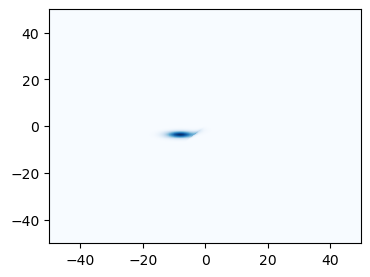

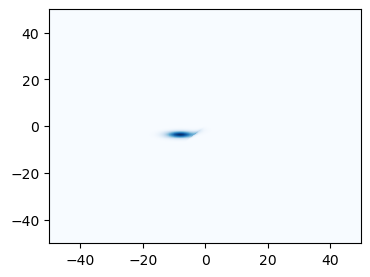

In [4]:
mean_kl=[]
sd_kl=[]
mean_kl_base=[]
sd_kl_base=[]
for mean in np.arange(0, 5, 0.5):

        para['X_m_mean']=para['X_f_mean']+mean
        dist['x_m']=[Gaussian_pdf(x,'X_m',para)*width for x in x_range]
        dist['x']=[dist['x_f'][i]*para['f']+dist['x_m'][i]*para['m'] for i in range(bin)]
        dist['t_x']=normialise([dist['x_f'][i]**para['f']*dist['x_m'][i]**para['m'] for i in range(bin)])  
        # plt.plot(x_range,dist['x'],label='x')
        # plt.plot(x_range,dist['t_x'],label='tilde_x')
        # plt.legend()
                
        print('top:x_f')
        print('right:x_m')
        mu_f=np.array(dist['x_f'])
        mu_m=np.array(dist['x_m'])
        output_base=OT(reg,x_range,mu_f,mu_m)

        num=100
        data=samples_groupby(data_generation(num,para))
        data_revised_base=barycenter_projection1(data,output_base,para)
        dist_project_base=dict()
        dist_project_base['x']=empirical_distribution(data_revised_base,dist)
        
        kl_tem.append(KL_divergence(dist['t_x'],dist['x']))
        kl_tem_base.append(KL_divergence(dist_project_base['x'],dist['x']))

    mean_kl.append(np.mean(kl_tem))
    #sd_kl.append(np.std(kl_tem))
    mean_kl_base.append(np.mean(kl_tem_base))
    #sd_kl_base.append(np.std(kl_tem_base))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

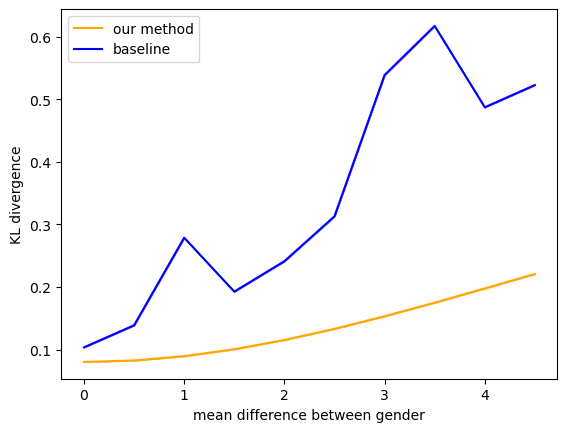

In [21]:
plt.plot(np.arange(0, 5, 0.5),mean_kl,label='our method',color='orange')
#plt.fill_between(np.arange(0, 5, 0.5),[mean_kl[i]-sd_kl[i] for i in range(len(mean_kl))],[mean_kl[i]+sd_kl[i] for i in range(len(mean_kl))],color='orange',alpha=0.5)
plt.plot(np.arange(0, 5, 0.5),mean_kl_base,label='baseline',color='blue')
#plt.fill_between(np.arange(0, 5, 0.5),[mean_kl_base[i]-sd_kl_base[i] for i in range(len(mean_kl))],[mean_kl_base[i]+sd_kl_base[i] for i in range(len(mean_kl))],color='blue',alpha=0.5)
plt.ylabel('KL divergence')
plt.xlabel('mean difference between gender')
plt.legend()

In [4]:
from scipy.stats import norm

In [6]:
norm.ppf(np.linspace(0,1,100),loc=para[name+'_mean'], scale=para[name+'_sd'])

NameError: name 'name' is not defined

In [28]:
FB=np.zeros(100)
for s in ['f','m']:
    name='X_'+s
    FB+=norm.ppf(np.linspace(0,1,100),loc=para[name+'_mean'], scale=para[name+'_sd'])*para[s]
FB

array([       -inf, -8.56611925, -8.12935083, -7.8521737 , -7.64362644,
       -7.47396203, -7.32952944, -7.20287239, -7.08945064, -6.98628438,
       -6.89130727, -6.80302456, -6.72031815, -6.64232857, -6.56838   ,
       -6.49793082, -6.43053972, -6.36584203, -6.30353259, -6.24335319,
       -6.18508321, -6.12853242, -6.07353548, -6.0199476 , -5.96764114,
       -5.91650281, -5.86643154, -5.81733655, -5.76913599, -5.72175558,
       -5.67512767, -5.6291903 , -5.58388651, -5.53916368, -5.49497299,
       -5.45126898, -5.40800911, -5.36515342, -5.32266423, -5.28050582,
       -5.23864425, -5.19704708, -5.15568321, -5.11452267, -5.07353648,
       -5.03269647, -4.99197517, -4.95134564, -4.91078136, -4.87025612,
       -4.82974388, -4.78921864, -4.74865436, -4.70802483, -4.66730353,
       -4.62646352, -4.58547733, -4.54431679, -4.50295292, -4.46135575,
       -4.41949418, -4.37733577, -4.33484658, -4.29199089, -4.24873102,
       -4.20502701, -4.16083632, -4.11611349, -4.0708097 , -4.02

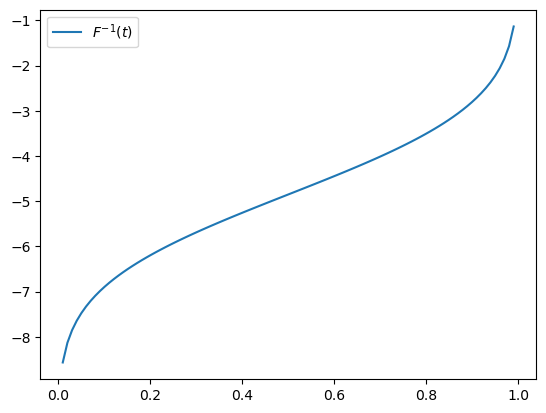

In [29]:
plt.plot(np.linspace(0,1,100),FB,label=r'$F^{-1}(t)$')
plt.legend()

In [35]:
minbin=np.floor((min(FB[1:])-horizen[0])/width)
maxbin=np.floor((max(FB[:-1])-horizen[0])/width)

In [61]:
mean_kl

[0.08045607922433902,
 0.08278556839131919,
 0.08965770999455376,
 0.10073586951868972,
 0.11549873611995197,
 0.13329494886376428,
 0.15340944652376115,
 0.17513179805008858,
 0.19781585708836896,
 0.22092169894572314]

top:x
right:tilde_xa
sum of violation of f: 9.055731044536666e-17
sum of violation of g: 1.450425523613992e-14
total cost: 1.9900896865002327
entropy: 6.508376564220064


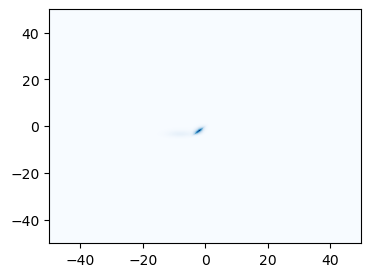

In [9]:
reg=0.01
print('top:x')
print('right:tilde_x'+u)
mu=np.array(dist['x'])
mu_t=np.array(dist['t_x'])
output=OT(reg,x_range,mu,mu_t)

In [22]:
num=1000
data=samples_groupby(data_generation(num,para))
data_revised=projection(data,output)

In [25]:
dist_original=dict()
dist_project=dict() #dict(keys=['x_'+i for i in name_list])

dist_original['hat_x']=empirical_distribution(data,dist)
dist_original['hat_x_f']=empirical_distribution(data[(data['S']=='f')],dist)
dist_original['hat_x_m']=empirical_distribution(data[(data['S']=='m')],dist)

dist_project['hat_tilde_x']=empirical_distribution(data_revised,dist)
dist_project['hat_tilde_x_f']=empirical_distribution(data_revised[(data_revised['S']=='f')],dist)
dist_project['hat_tilde_x_m']=empirical_distribution(data_revised[(data_revised['S']=='m')],dist)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


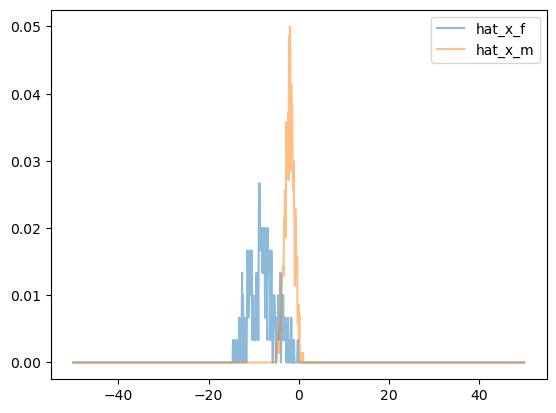

In [35]:
for key,value in dist_original.items():
    if key[-1]!='x':
        plt.plot(x_range,value,label=key,alpha=0.5)
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


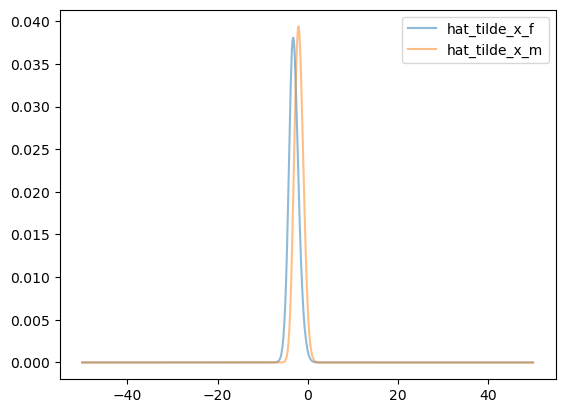

In [36]:
for key,value in dist_project.items():
    if key[-1]!='x':
        plt.plot(x_range,value,label=key,alpha=0.5)
    plt.legend()